## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [273]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

def BandpassFilter(signal, low_bpm, high_bpm, fs=125):
    """Bandpass filter the signal between low/high"""
    low_f = low_bpm/60 # bpm to Hz
    high_f = high_bpm/60
    b, a = sp.signal.butter(3, (low_f, high_f), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaRefFile(ref_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(ref_fl)['BPM0']
    return data

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def FrequencyEstimator(ppg,accx,accy,accz,fs=125,window_time=8,windows_time_shift=2):
    """
    Runs the pulse rate estimator of a moving window of 2sec estimating the pulse rate in the last 8seconds
    Input: data (ppg,accx,accy,accz)
           fs sampling rate
           windows_length (default 8 seconds)
           window_shift (default 2 seconds)
    Returns:
        Pulse rate every 2 seconds
    """
    #Bandpass the ppg signal
    ppg_f=BandpassFilter(ppg,40,240)
    #get the accellerometer strenght vector (accy is subsctracted by its mean)
    accx=BandpassFilter(accx,40,240)
    accy=BandpassFilter(accy,40,240)
    accz=BandpassFilter(accz,40,240)
    accy_m=accy-np.mean(accy)
    acc=np.sqrt(accx**2+accy_m**2+accz**2)
    acc_f=BandpassFilter(acc,40,240)

    #window_time= 8 # 8seconds
    n_sample_window= window_time*fs #
    #window_shift_time= 2 #2 seconds is the refresh time
    n_sample_window_shift=window_shift_time*fs
    estimate_bpm=[]
    #confidence_levels=[]
    for sample in range(0,len(ppg_filt)-n_sample_window,n_sample_window_shift):
        #Calculate the fft of the signal
        freqs=np.fft.rfftfreq(n_sample_window,1/fs)
        fft_val=np.abs(np.fft.rfft(ppg_filt[sample:sample+n_sample_window]))
         #Calculate the fft of the accellerometer
        acc_fft=np.abs(np.fft.rfft(acc_filt[sample:sample+n_sample_window]))
        
        freq_peak_acc=freqs[np.argmax(acc_fft)]
        freq_peak_ppg=freqs[np.argmax(fft_val)]
        
        estimate_bpm.append(freq_peak_ppg*60)
        #sp.signal.find_peaks(fft_val,height=2000,distance=10)
        
        #print("Estimated freq:",freqs[peaks[0]]*60)
   
    #compute the average value and confidence level
    return estimate_bpm
    
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    reference_pulse_rate=LoadTroikaRefFile(ref_fl)
    print("Type:",type(reference_pulse_rate),reference_pulse_rate.shape)
    #print("Ref:",reference_pulse_rate)
    # Compute pulse rate estimates and estimation confidence.
    pulse_rate_estimate=FrequencyEstimator(ppg,accx,accy,accz)
    pre=np.array(pulse_rate_estimate)
    
    print("Estimate:",pre.shape,pre)
    errors=np.abs(pulse_rate_estimate-reference_pulse_rate)
    list_ref=np.aslist(reference_pulse_rate)
    errors=[abs(pulse_rate_estimate[i]-list_ref[i]) for i in range(0,len(list_ref))]
    print("Errors:",errors)
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

Retrieve the list of data and reference files 

In [2]:
data_fls, ref_fls=LoadTroikaDataset()

In [20]:
for data_file in data_fls:
    print("Data File:",data_file," len:",LoadTroikaDataFile(data_file).shape)

Data File: ./datasets/troika/training_data\DATA_01_TYPE01.mat  len: (4, 37937)
Data File: ./datasets/troika/training_data\DATA_02_TYPE02.mat  len: (4, 37850)
Data File: ./datasets/troika/training_data\DATA_03_TYPE02.mat  len: (4, 35989)
Data File: ./datasets/troika/training_data\DATA_04_TYPE01.mat  len: (4, 27576)
Data File: ./datasets/troika/training_data\DATA_04_TYPE02.mat  len: (4, 37250)
Data File: ./datasets/troika/training_data\DATA_05_TYPE02.mat  len: (4, 37328)
Data File: ./datasets/troika/training_data\DATA_06_TYPE02.mat  len: (4, 38373)
Data File: ./datasets/troika/training_data\DATA_07_TYPE02.mat  len: (4, 36650)
Data File: ./datasets/troika/training_data\DATA_08_TYPE02.mat  len: (4, 40803)
Data File: ./datasets/troika/training_data\DATA_10_TYPE02.mat  len: (4, 38042)
Data File: ./datasets/troika/training_data\DATA_11_TYPE02.mat  len: (4, 36500)
Data File: ./datasets/troika/training_data\DATA_12_TYPE02.mat  len: (4, 37316)


In [274]:
pest=RunPulseRateAlgorithm(data_fls[0], ref_fls[0])

Type: <class 'numpy.ndarray'> (148, 1)
Estimate: (148,) [ 75.   75.   75.   75.   75.   67.5  75.   75.   75.   75.   75.   82.5
  75.   67.5  67.5  67.5  67.5  67.5  67.5  82.5 165.  165.  157.5 157.5
 157.5 157.5 157.5 157.5 157.5 157.5 157.5 157.5 157.5 157.5 150.  150.
 157.5 157.5 157.5 157.5 157.5 157.5 157.5 150.  150.  165.  165.  165.
 165.  127.5 127.5 127.5 135.  165.  172.5 172.5 172.5 172.5 180.  172.5
 172.5 172.5 172.5 172.5 172.5 172.5 172.5 172.5 172.5 180.  180.  180.
 180.  180.  180.  180.  180.  180.  157.5 157.5 165.  165.  165.  165.
 165.  165.  165.  165.  165.  165.  157.5 157.5 165.  165.  165.  165.
 165.  165.  165.  165.  165.  142.5 142.5 142.5 165.  150.  150.  180.
 180.  172.5 172.5 172.5 172.5 172.5 180.  172.5 172.5 172.5 180.  180.
 172.5 180.  165.  165.   90.   90.   90.  180.  180.  180.   90.   90.
  90.  172.5 172.5 172.5 172.5 187.5  82.5 165.  165.  157.5 157.5 157.5
 157.5 157.5 157.5 157.5]


AttributeError: module 'numpy' has no attribute 'aslist'

In [193]:
rfl0=ref_fls[0]

In [205]:
rf0=LoadTroikaRefFile(rfl0)

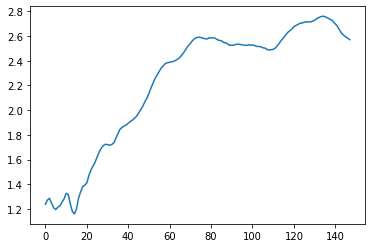

In [208]:
plt.plot(rf0/60)

All data files have approximately the same lenght wich is =40000/fs except 1 that is shorter

In [21]:
fs=125 #sample rate  in Hertz
ts=1/fs #time samples in seconds
print("Time lenght:",40000/fs)

Time lenght: 320.0


Duration of each files is approximately 5 minutes

Let's plot one ppg file

In [77]:
ppg,accx,accy,accz=LoadTroikaDataFile(data_fls[0])

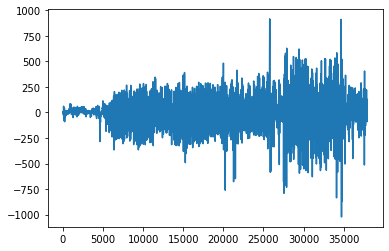

In [136]:
plt.plot(ppg)

In [158]:
#get the accellerometer strenght vector (accy is subsctracted by its mean)
accx=BandpassFilter(accx,40,240)
accy=BandpassFilter(accy,40,240)
accz=BandpassFilter(accz,40,240)
accy_m=accy-np.mean(accy)
acc=np.sqrt(accx**2+accy_m**2+accz**2)

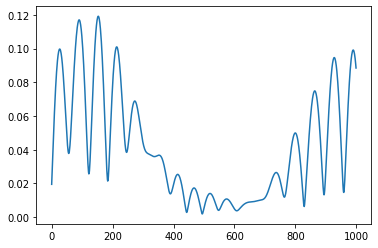

In [159]:
plt.plot(acc[0:1000])

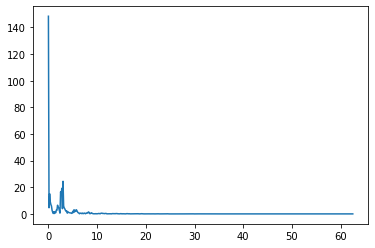

In [160]:
freqs=np.fft.rfftfreq(len(acc[20000:21000]),1/fs)
fft_acc=np.abs(np.fft.rfft(acc[30000:31000]))
plt.plot(freqs,fft_acc)

In [161]:
import matplotlib.pyplot as plt

In [162]:
import mpld3
mpld3.enable_notebook()

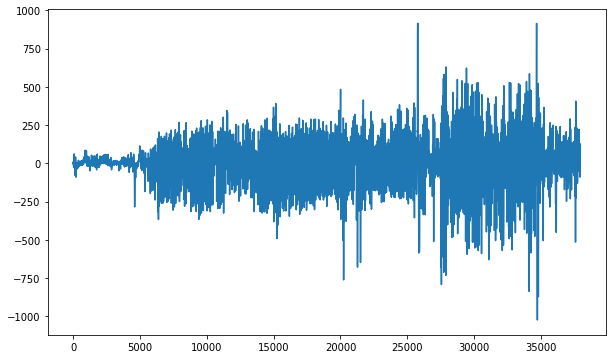

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(ppg)

As expected the signal amplitude varies in time since the subjects are doing a threamill test with different intensities, starting and finishing at rest.
Let's see a couple of sections 8 seconds long

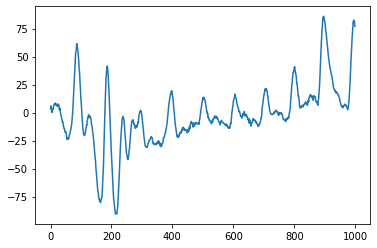

In [164]:
plt.plot(ppg[0:1000])

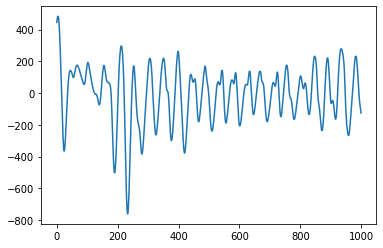

In [165]:
plt.plot(ppg[20000:21000])

In [166]:
ppg_filt=BandpassFilter(ppg,40,240)

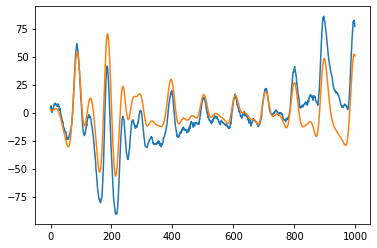

In [167]:
plt.plot(ppg[0:1000])
plt.plot(ppg_filt[0:1000])

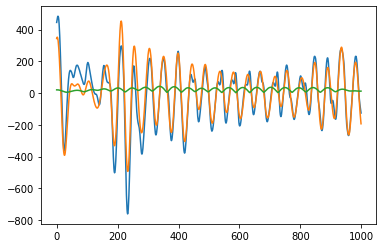

In [168]:
plt.plot(ppg[20000:21000])
plt.plot(ppg_filt[20000:21000])
plt.plot(acc[20000:21000]*100)

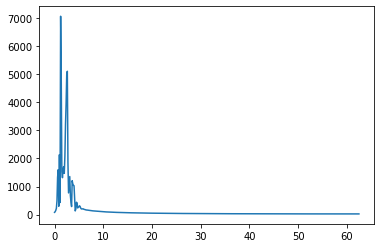

In [169]:
test_ppg=ppg_filt[0:1000]
freqs=np.fft.rfftfreq(len(test_ppg),1/fs)
fft_mag=np.abs(np.fft.rfft(test_ppg))
plt.plot(freqs,fft_mag)

In [170]:
peaks=sp.signal.find_peaks(fft_mag,height=2000,distance=10)

In [171]:
freqs[peaks[0]]

array([1.25 , 2.625])

In [172]:
freqs[peaks[0]]*60

array([ 75. , 157.5])

Resting heart rate frequency for this subject is 75 bpm

(0, 10)

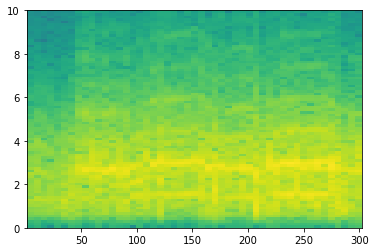

In [173]:
spec=plt.specgram(ppg_filt,Fs=fs,NFFT=1024,noverlap=256)
plt.ylim(0,10)

In [174]:
len(acc)

37937

In [209]:
fs

125

In [210]:
acc_filt=BandpassFilter(acc,40,240)

(0, 10)

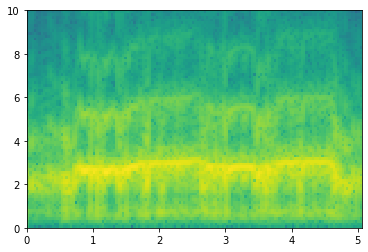

In [212]:
specsm, freqsm, _, _ = plt.specgram(acc_filt, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, len(acc)/fs/60])
plt.ylim(0,10)


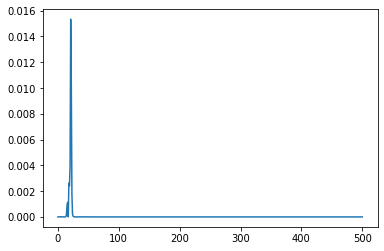

In [213]:
plt.plot(specsm[:,100])

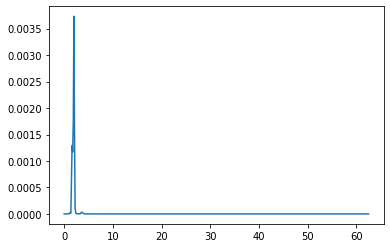

In [234]:
plt.plot(freqsm,specsm[:,140])


In [237]:
peaks=sp.signal.find_peaks(specsm[:,145],distance=10)
maxpeak=freqsm[np.argmax(specsm[:,145])]

In [242]:
len(freqsm)

501

In [244]:
max_freq_acc=[freqsm[np.argmax(specsm[:,i])]*60 for i in range(0,148)]

In [245]:
max_freq_acc

[120.0,
 112.5,
 120.0,
 120.0,
 120.0,
 112.5,
 112.5,
 135.0,
 135.0,
 135.0,
 142.5,
 135.0,
 127.5,
 135.0,
 120.0,
 120.0,
 120.0,
 120.0,
 127.5,
 120.0,
 120.0,
 157.5,
 157.5,
 165.0,
 157.5,
 157.5,
 157.5,
 157.5,
 157.5,
 150.0,
 157.5,
 157.5,
 157.5,
 157.5,
 150.0,
 150.0,
 157.5,
 157.5,
 157.5,
 150.0,
 150.0,
 150.0,
 150.0,
 157.5,
 157.5,
 157.5,
 165.0,
 165.0,
 165.0,
 172.5,
 172.5,
 172.5,
 150.0,
 127.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 172.5,
 180.0,
 180.0,
 180.0,
 180.0,
 180.0,
 180.0,
 180.0,
 180.0,
 180.0,
 172.5,
 157.5,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 150.0,
 157.5,
 157.5,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 165.0,
 157.5,
 142.5,
 142.5,
 150.0,
 150.0,
 165.0,
 157.5,
 157.5,
 157.5,
 150.0,
 172.5,
 172.5,
 172.5,
 172.5,
 180.0,
 172.5,
 172.5,
 172.5,
 180.0,
 180.0,
 180.0,
 165.0,
 172.5,
 180.0,
 180.0,


In [224]:
freqsm[peaks[0]]*60

array([  37.5,  142.5,  277.5,  412.5,  555. ,  705. ,  847.5,  952.5,
       1027.5, 1102.5, 1177.5, 1260. , 1335. , 1410. , 1485. , 1560. ,
       1635. ])

In [ ]:
Calculate the average heart rate frequency in a time span of 8s and update every 2 seconds

Start time(s): 0.0


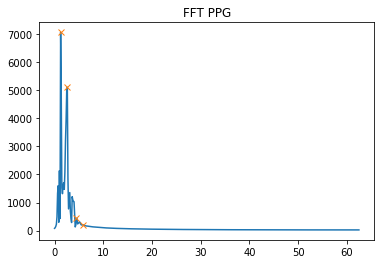

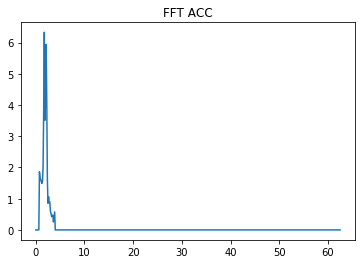

Estimated freq: [ 75.  157.5]
Start time(s): 40.0


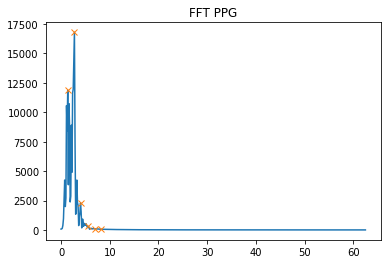

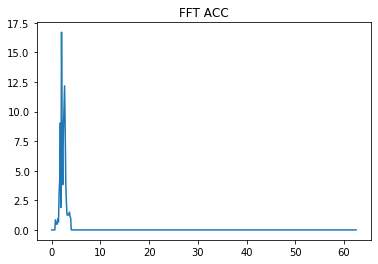

Estimated freq: [ 82.5 165.  240. ]
Start time(s): 80.0


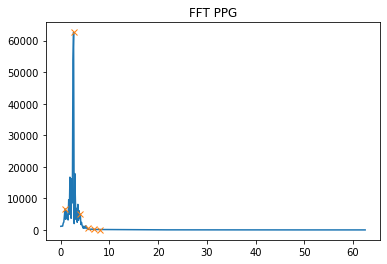

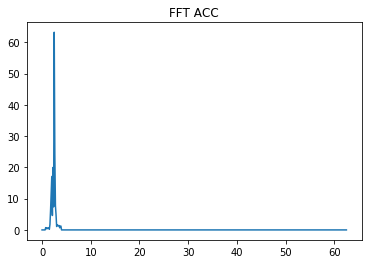

Estimated freq: [ 52.5 157.5 240. ]
Start time(s): 120.0


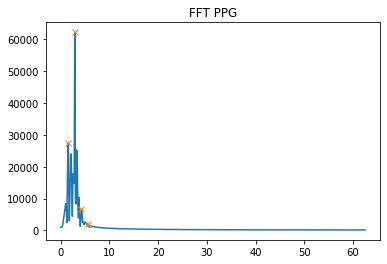

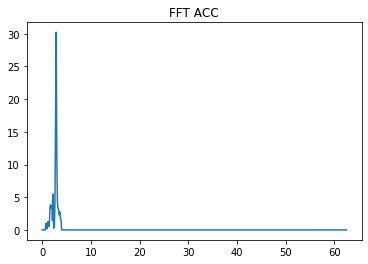

Estimated freq: [ 90.  172.5 255. ]
Start time(s): 160.0


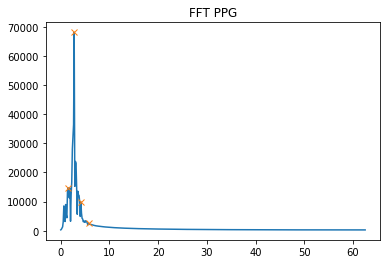

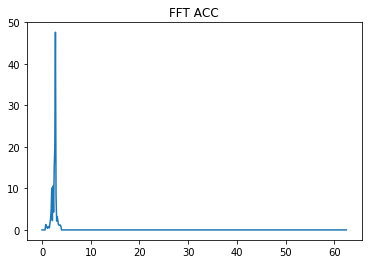

Estimated freq: [ 90.  165.  247.5 345. ]
Start time(s): 200.0


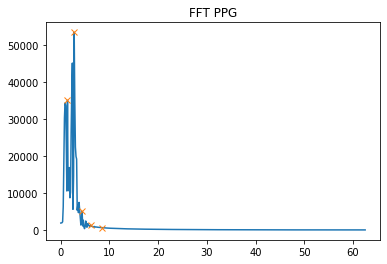

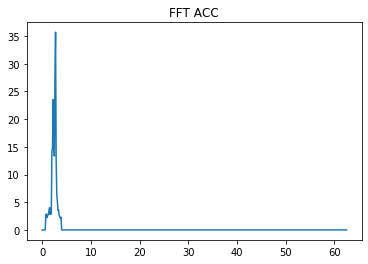

Estimated freq: [ 82.5 165.  262.5]
Start time(s): 240.0


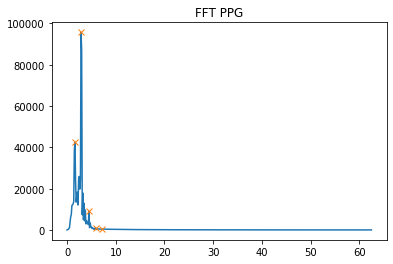

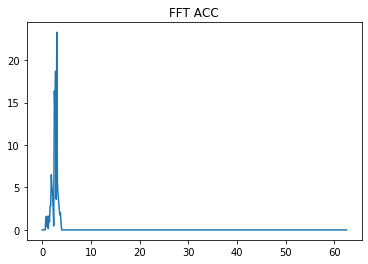

Estimated freq: [ 97.5 172.5 270. ]
Start time(s): 280.0


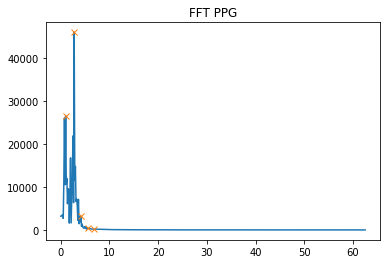

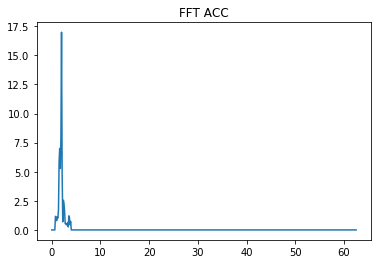

Estimated freq: [ 60.  165.  247.5]


In [281]:
window_time= 8 # 8seconds
n_sample_window= 8*fs #
window_shift_time= 2 #2 seconds is the refresh time
n_sample_window_shift=window_shift_time*fs
i=0
for sample in range(0,len(ppg_filt)-n_sample_window,n_sample_window_shift):
    #print(i," Sample start:",sample, "Sample end:",sample+n_sample_window)
    #Calculate the fft of the signal
    freqs=np.fft.rfftfreq(n_sample_window,1/fs)
    fft_val=np.abs(np.fft.rfft(ppg_filt[sample:sample+n_sample_window]))
    peaks,_=sp.signal.find_peaks(fft_val,height=5,distance=10)
    acc_fft=np.abs(np.fft.rfft(acc_filt[sample:sample+n_sample_window]))
    acc_fft[freqs <= 40/60.0] = 0.0
    acc_fft[freqs >= 240/60.0] = 0.0
    if i%20==0:
        #print(acc_fft)
        print("Start time(s):",sample/fs)
        #plt.plot(ppg_filt[sample:sample+n_sample_window])
        #plt.show()
        #plt.plot(acc_filt[sample:sample+n_sample_window])
        #plt.show()
        plt.plot(freqs,fft_val)
        plt.plot(freqs[peaks],fft_val[peaks],'x')
        plt.title("FFT PPG")
        plt.show()
         
        plt.plot(freqs,acc_fft)
        plt.title("FFT ACC")
        plt.show()
        
        peaks=sp.signal.find_peaks(fft_val,height=2000,distance=10)
        
        print("Estimated freq:",freqs[peaks[0]]*60)
    #Calculate the fft of the accellerometer
    #compute the average value and confidence level
    i+=1

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 